In [1]:
# imports
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

In [3]:

# load data
all_data = loadmat('./data/sample_1.mat')
sample_data = np.array(all_data['data'])
# extract spike times for later comparison
spike_times = np.array(all_data['spike_times'])
print('# of actual spikes:', len(spike_times[0][0][0]))

# of actual spikes: 3214


In [4]:
# parameters
seconds = 120
sr = 24000 # sample rate = 24kHz

data = sample_data[0][:round(seconds*sr)]
ground_truth_spikes = spike_times[0][0][0][:round(seconds*sr)]

mean_data = np.mean(data)
std_data = np.std(data)

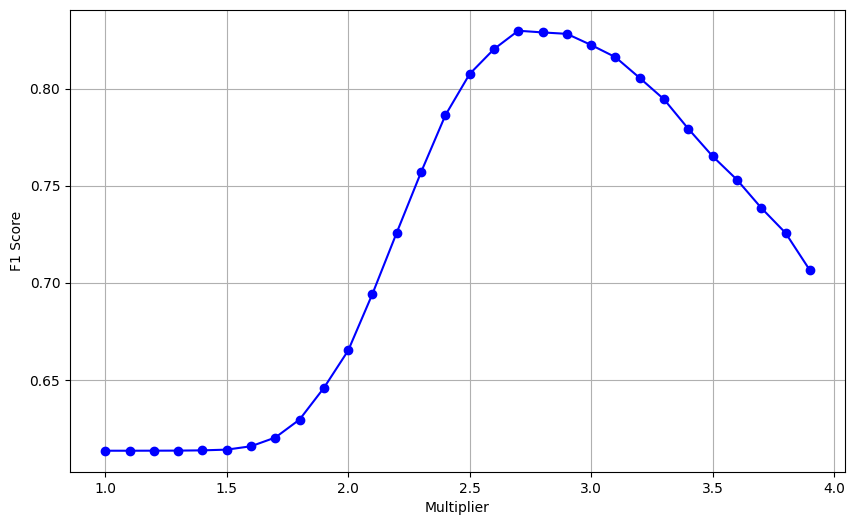

Best multiplier: 2.7000000000000015, F1 score: 0.8297609047577668


In [5]:
def detect_spikes(data, multiplier):
    spike_times_start_only = []
    spike_times_reconstructed = np.where(data >= np.mean(data) + multiplier * np.std(data))[0]
    
    if len(spike_times_reconstructed) > 0:
        spike_times_start_only.append(spike_times_reconstructed[0])
        spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

    return np.array(spike_times_start_only)


def calculate_f1_score(detected_spikes, ground_truth_spikes, sr, tolerance=0.01):
    # convert tolerance (time duration in seconds: 0.001 = 1ms) to number of samples
    tolerance_in_samples = tolerance * sr
    detected_binary = np.zeros_like(data)

    # set values to 1 where spikes occur (detected_binary[start_index:end_index] = 1)
    for spike in (detected_spikes / sr):
        detected_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    ground_truth_binary = np.zeros_like(data)
    for spike in (ground_truth_spikes / sr):
        ground_truth_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    # calculate F1 score
    f1 = f1_score(ground_truth_binary, detected_binary)
    
    return f1

# test different multiplier values for threshold
multipliers = np.arange(1.0, 4.0, 0.1) 
f1_scores = []

for multiplier in multipliers:
    detected_spikes = detect_spikes(data, multiplier)
    f1 = calculate_f1_score(detected_spikes, spike_times[0][0][0][:round(seconds*sr)], sr)
    f1_scores.append(f1)

# plot F1 scores as a function of the multiplier
plt.figure(figsize=(10, 6))
plt.plot(multipliers, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Multiplier')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

# get best multiplier based on F1 score
best_f1 = max(f1_scores)
best_multiplier = multipliers[np.argmax(f1_scores)]
print(f"Best multiplier: {best_multiplier}, F1 score: {best_f1}")

In [6]:
# apply threshold to raw data
spike_times_reconstructed = np.where(data >= mean_data + best_multiplier * std_data)[0]
print(mean_data + best_multiplier * std_data)
spike_times_start_only = []
spike_times_start_only.append(spike_times_reconstructed[0])
# if data is above threshold back to back, count all occurences as one single spike
spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

24.956745385531484


In [7]:
#@ Alice
len(spike_times_start_only)
spike_times_start_only[:20]

[np.int64(566),
 np.int64(1145),
 np.int64(2034),
 np.int64(3043),
 np.int64(3807),
 np.int64(4191),
 np.int64(5949),
 np.int64(7009),
 np.int64(8028),
 np.int64(8132),
 np.int64(11667),
 np.int64(11811),
 np.int64(12071),
 np.int64(12888),
 np.int64(14254),
 np.int64(14917),
 np.int64(15379),
 np.int64(19950),
 np.int64(22220),
 np.int64(22531)]

In [17]:
# only runs this cell if seconds parameter is below 5, otherwise the plot gets too convoluted
if seconds < 5:
    # display data
    plt.figure(figsize=(25,6))
    plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
    plt.xlim(0, seconds)

    # plot where we think a spike is 
    for i, spike in enumerate(spike_times_start_only):
        # plt.axvline(spike/sr - .0008, c='red', alpha=0.5)
        plt.axvspan(spike/sr - .0008, spike/sr + .001, facecolor='r', alpha=0.2)
        plt.text(spike/sr - 0.006, 110 if i%2 == 0 else 100, i+1, c='r')

    # plot ground truth for reference
    for i, spike in enumerate(ground_truth_spikes / sr):
        if round(spike*24000) > round(seconds*24000): break
        plt.axvline(spike, c='k', alpha=1)
        plt.text(spike - 0.006, 85 if i%2 == 0 else 75, i+1, c='b')
        
    plt.show()

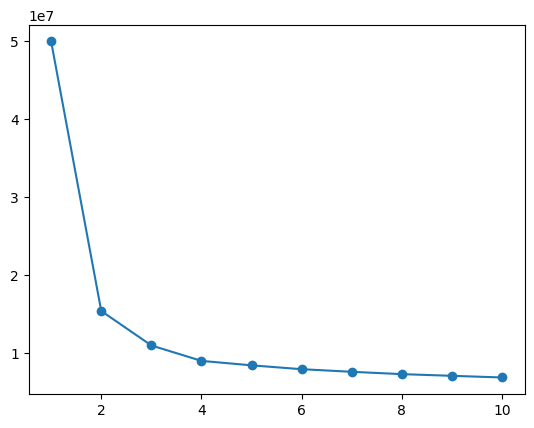

In [8]:
number_of_spikes = len(spike_times_start_only)

# get max & min voltage of all spikes (for plotting purposes)
ymax = 0
ymin = 0
spikes = []
for spike in spike_times_start_only:
    start = round(spike - .0008 * sr)
    end = round(spike + .001 * sr)
    if np.max(data[start:end]) > ymax: ymax = np.max(data[start:end])
    if np.min(data[start:end]) < ymin: ymin = np.min(data[start:end])
    # store detected spikes in list
    spikes.append(data[start:end])



inertias = []
# determine best number of clusters via elbow plot
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(spikes)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.show()


In [9]:
len(inertias)

10

In [10]:
inertias[:5]

[49880185.89985049,
 15389809.258938167,
 10981402.969036976,
 9006211.668302825,
 8435563.951573694]

In [11]:
len(spikes[1])

43

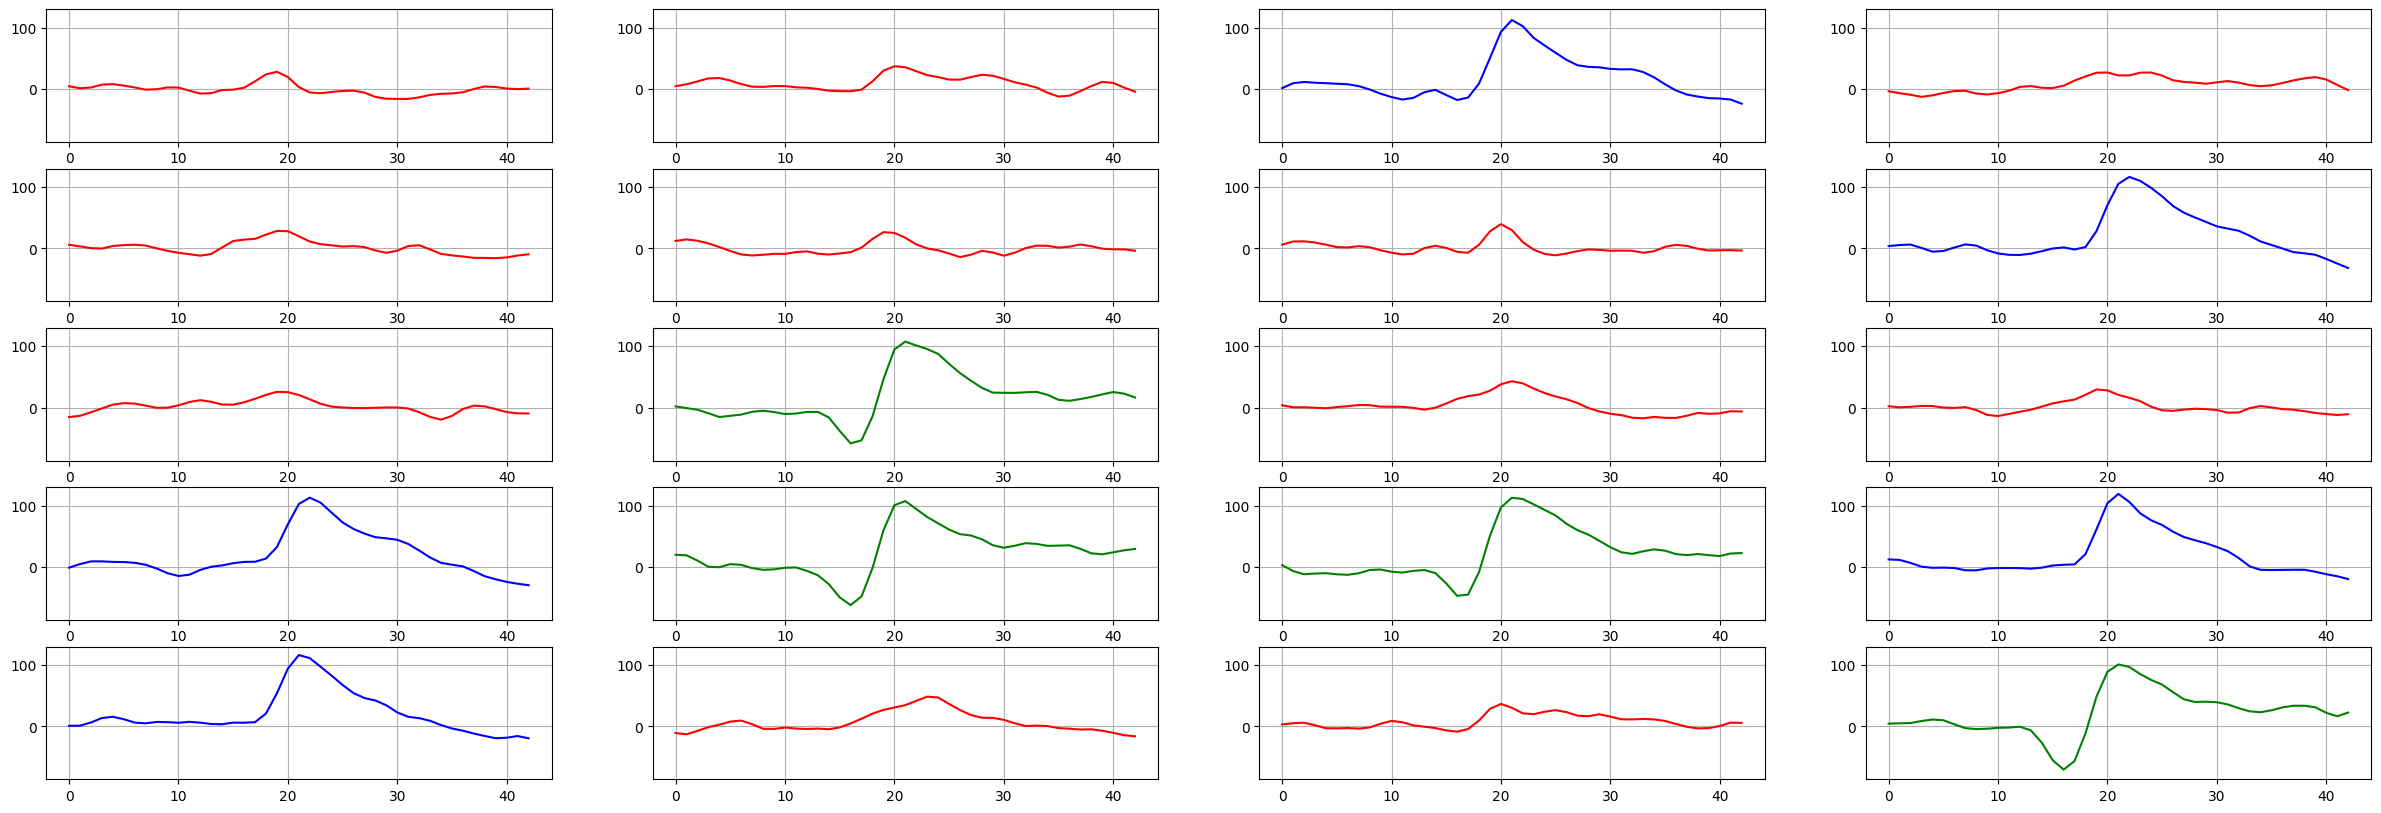

In [12]:
# apply final clustering algorithm based on optimal number of clusters
n_clusters = 3
kmeans_final = KMeans(n_init=10, n_clusters=n_clusters)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b', 'orange']

# plot first 20 spikes in different colors to see if clustering worked
plt.figure(figsize=(30,10))
for i, spike in enumerate(spikes[:20]):
    plt.subplot(5, 4, i+1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(spike, c=colors[classes[i]])
plt.show()

# of spikes: 3141


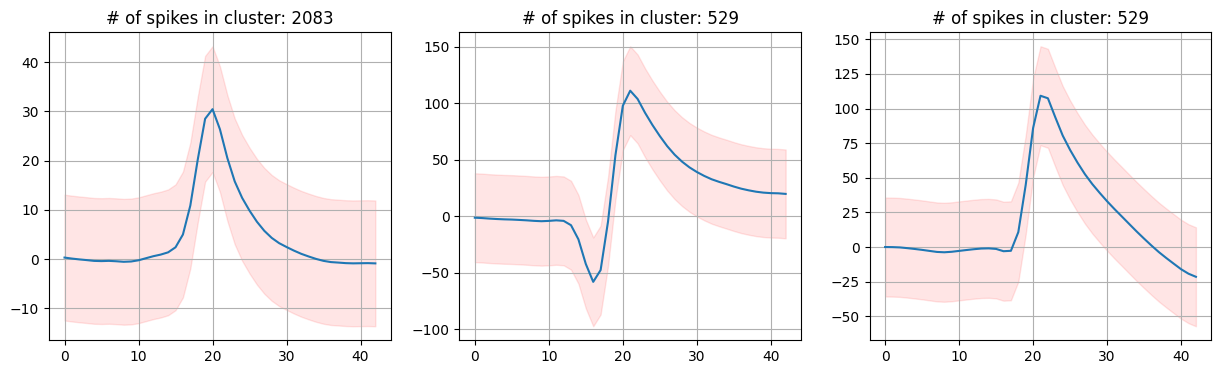

In [13]:
plt.figure(figsize=(5*n_clusters, 4))

print('# of spikes:', number_of_spikes)

# compute mean & std deviation of each spike class & plot them
for i in range(n_clusters):
    x = np.arange(0, 43, 1)
    classIndices = np.where(classes == i)[0]
    
    meanSpike = np.mean(np.array(spikes)[classIndices], axis=0)
    deviation = np.std(np.array(spikes)[classIndices])
    
    plt.subplot(1, n_clusters, i+1)
    plt.title(f'# of spikes in cluster: {len(classIndices)}')
    plt.plot(meanSpike)
    plt.fill_between(x, meanSpike - deviation, meanSpike + deviation, alpha=0.1, color='r')
    plt.grid()
plt.show()

# Gap Statistics Implementation according to Article
source: https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
supported by Chatgpt

In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def generate_reference_datasets(X, B=10):
    """
    Erzeugt B zufällige Referenzdatensätze, die innerhalb des gleichen Wertebereichs wie X liegen.
    
    Parameters:
    X (ndarray): Der echte Datensatz (n x m), wobei n die Anzahl der Datenpunkte und m die Anzahl der Dimensionen ist.
    B (int): Die Anzahl der Referenzdatensätze, die erzeugt werden sollen.
    
    Returns:
    List of ndarray: Eine Liste von B zufällig generierten Referenzdatensätzen, jeder hat die gleiche Form wie X.
    """
    n, m = X.shape
    min_vals = np.min(X, axis=0)  # Minimumwerte für jede Dimension
    max_vals = np.max(X, axis=0)  # Maximumwerte für jede Dimension
    
    reference_datasets = []
    
    for _ in range(B):
        # Gleichmäßig verteilte Zufallswerte innerhalb der Wertebereiche von X
        random_data = np.random.uniform(low=min_vals, high=max_vals, size=(n, m))
        reference_datasets.append(random_data)
    
    return reference_datasets

def compute_dispersion(X, labels, k):
    """
    Berechnet die Dispersion (innerhalb der Cluster) für die Cluster in den Daten X.
    
    Parameters:
    X (ndarray): Der Datensatz.
    labels (ndarray): Die Cluster-Labels für die Datenpunkte in X.
    k (int): Die Anzahl der Cluster.
    
    Returns:
    float: Die Gesamt-Dispersion (Summe der quadratischen Distanzen) für alle Cluster.
    """
    dispersion = 0
    for i in range(k):
        cluster_points = X[labels == i]  # Punkte, die zu Cluster i gehören
        if len(cluster_points) > 0:
            centroid = np.mean(cluster_points, axis=0)  # Berechne das Clusterzentrum
            dispersion += np.sum((cluster_points - centroid) ** 2)  # Summe der quadrierten Distanzen
    
    return dispersion

def gap_statistic(X, k_max=10, B=10):
    """
    Berechnet die Gap Statistic für verschiedene Cluster-Anzahlen.
    
    Parameters:
    X (ndarray): Der originale Datensatz (n x m).
    k_max (int): Maximale Anzahl der zu testenden Cluster.
    B (int): Anzahl der zu generierenden Referenzdatensätze.
    
    Returns:
    ndarray: Die Gap-Werte für jede Cluster-Anzahl von 1 bis k_max.
    """
    gap_values = np.zeros(k_max)
    reference_datasets = generate_reference_datasets(X, B)
    
    for k in range(1, k_max + 1):
        # Führe KMeans auf den echten Daten durch
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = kmeans.labels_
        Wk = compute_dispersion(X, labels, k)  # Dispersion für echte Daten
        
        # Berechne Wk' für die Referenzdatensätze
        Wk_b = np.zeros(B)
        for b in range(B):
            ref_data = reference_datasets[b]
            kmeans_ref = KMeans(n_clusters=k, random_state=0).fit(ref_data)
            ref_labels = kmeans_ref.labels_
            Wk_b[b] = compute_dispersion(ref_data, ref_labels, k)
        
        # Berechne die Gap Statistic
        log_Wk_b = np.mean(np.log(Wk_b))
        log_Wk = np.log(Wk)
        gap_values[k - 1] = log_Wk_b - log_Wk  # Differenz zwischen zufälligen und echten Daten
    
    return gap_values



# Berechne die Gap Statistic für Clusteranzahlen von 1 bis 10

gap_values = gap_statistic(np.array(spikes), k_max=10, B=10)
print("Gap-Werte für Clusteranzahlen von 1 bis 10:", gap_values)

Gap-Werte für Clusteranzahlen von 1 bis 10: [1.04378122 2.18137422 2.4947556  2.6745886  2.69599904 2.70926275
 2.75949175 2.84077472 2.86300311 2.87778784]


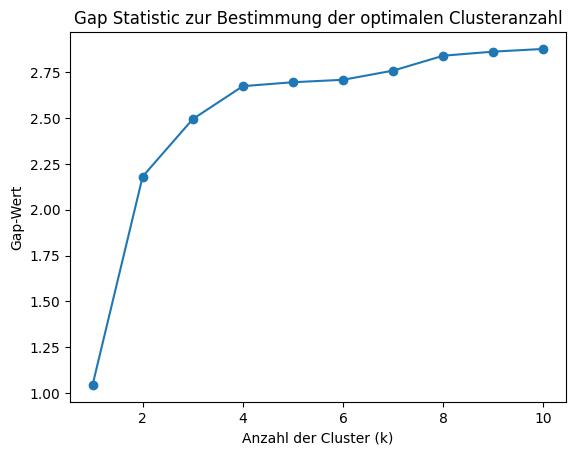

In [15]:
# Plot der Gap-Werte
plt.plot(range(1, 11), gap_values, marker='o')
plt.xlabel('Anzahl der Cluster (k)')
plt.ylabel('Gap-Wert')
plt.title('Gap Statistic zur Bestimmung der optimalen Clusteranzahl')
plt.show()

 Wenn wir uns für den hohen Gap-Wert k=4 entscheiden bedeutet das, dass die Dispersion (z.B. die Summe der quadratischen Abstände der Punkte zu den Clusterzentren) für die echten Daten geringer ist als die durchschnittliche Dispersion für die zufällig generierten Daten 𝑊𝑘′. Dies zeigt, dass die echten Daten eine klarere und dichter gepackte Clusterstruktur aufweisen, was darauf hindeutet, dass sie besser organisiert sind.

  If we opt for the high gap value k=4, this means that the dispersion (e.g. the sum of the squared distances of the points to the cluster centers) for the real data is lower than the average dispersion for the randomly generated data 𝑊𝑘′. This shows that the real data have a clearer and more densely packed cluster structure, indicating that they are better organized.

# Gap Statistics - Implementation of Gap Statistics according to Notebook

source: https://www.kaggle.com/code/mallikarjunaj/gap-statistics


Gap-Statistics was introduced by Robert Tibshirani in the year 2000 at Stanford.
Determining the ideal number of clusters in a dataset is one of the key tasks in the clustering exercise. After the elbow method gap-statistics is one of the most prominent ones used. The basic idea is to compute the goodness of clustering measure based on average dispersion compared to a reference distribution for an increasing number of clusters. If you find this notebook helpful then upvote and also comment.


In this notebook we discuss what gap statistics is all about , how to implement it and an example.
Firstly we try understand on earth what 'Gap' in gap statistics mean. As shown in the below example we see that there are 2 clusters formed and a graph of number of clusters vs within sum of squares.
![image.png](attachment:392a836f-055c-4f67-8746-049e90d830fb.png)
###### ***(Fig 1) Image courtesy: Robert Tibshirani's paper on gap statistics***
Here we see from elbow method that '2' is the optimal number of clusters formed. In gap statistics a log of within sum of squres of data(log(W_data)) and a log of within sum of squraes of uniform data(log(W_uniform)) are considered. Below image shows the plot of log(W_data) and log(W_uniform) with respect to number of clusters. W_uniform is basically a simulated and averaged distribution of the within-cluster distances.

![image.png](attachment:83df652f-b582-4f0a-b8d6-b0343588c55a.png)
###### ***(Fig 2) Image courtesy: Robert Tibshirani's paper on gap statistics***
Now gap is found out between these two curves and is ploted. Thats why the name gap statistics.
The formula for finding gap is
![image.png](attachment:303d9caa-47a2-4313-98de-1ee214c04fd8.png)

![image.png](attachment:a1db39e1-878a-4100-a95b-eb060dffc2b8.png)
###### ***(Fig 3) Image courtesy: Robert Tibshirani's paper on gap statistics***
To find the optimal number of clusters we find the first peak that is '2' which is true according to fig 1.
For detailed explaination on math of gap statistics you can refer to [Trevor Hastie, Robert Tibshirani and Guenther Walther, Estimating the number of clusters in a data set via the gap statistics (2000)](https://doi.org/10.1111/1467-9868.00293)

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import time
import hashlib
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, Birch

In [103]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs=3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = [{'clusterCount':[], 'gap':[]}]

    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
            
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index-1] = gap
        
        results.append({'clusterCount':k, 'gap':gap})



    # Extracting clusterCount and gap values into separate lists

    return (gaps.argmax() + 1, results)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal


In [104]:
len(spikes)
data_array = np.array(spikes)

In [105]:
k, results = optimalK(data_array,maxClusters=10)
cluster_count_list = [entry['clusterCount'] for entry in results]
gap_list = [entry['gap'] for entry in results]
print('Optimal k is: ', k)

Optimal k is:  8


In [107]:

gap_list


[[],
 np.float64(-8.398364708939901),
 np.float64(-7.242077632542491),
 np.float64(-6.913656136618902),
 np.float64(-6.726684975171457),
 np.float64(-6.7121947886508995),
 np.float64(-6.6614726445258405),
 np.float64(-6.585542533380254),
 np.float64(-6.548588686026825),
 np.float64(-6.542628486332362)]

In [108]:
cluster_count_list

[[], 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Results of the calculated gaps
## The first peak is the optimal k value

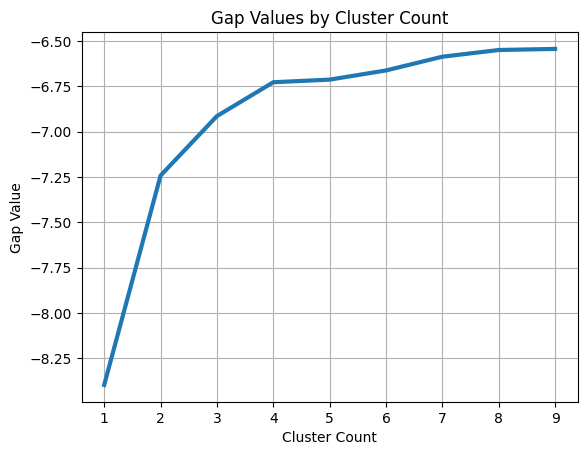

In [109]:
# Plotting the Gap Values
plt.plot(cluster_count_list[1:],gap_list[1:], linewidth=3)
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

# Applying the optimal k value to the data

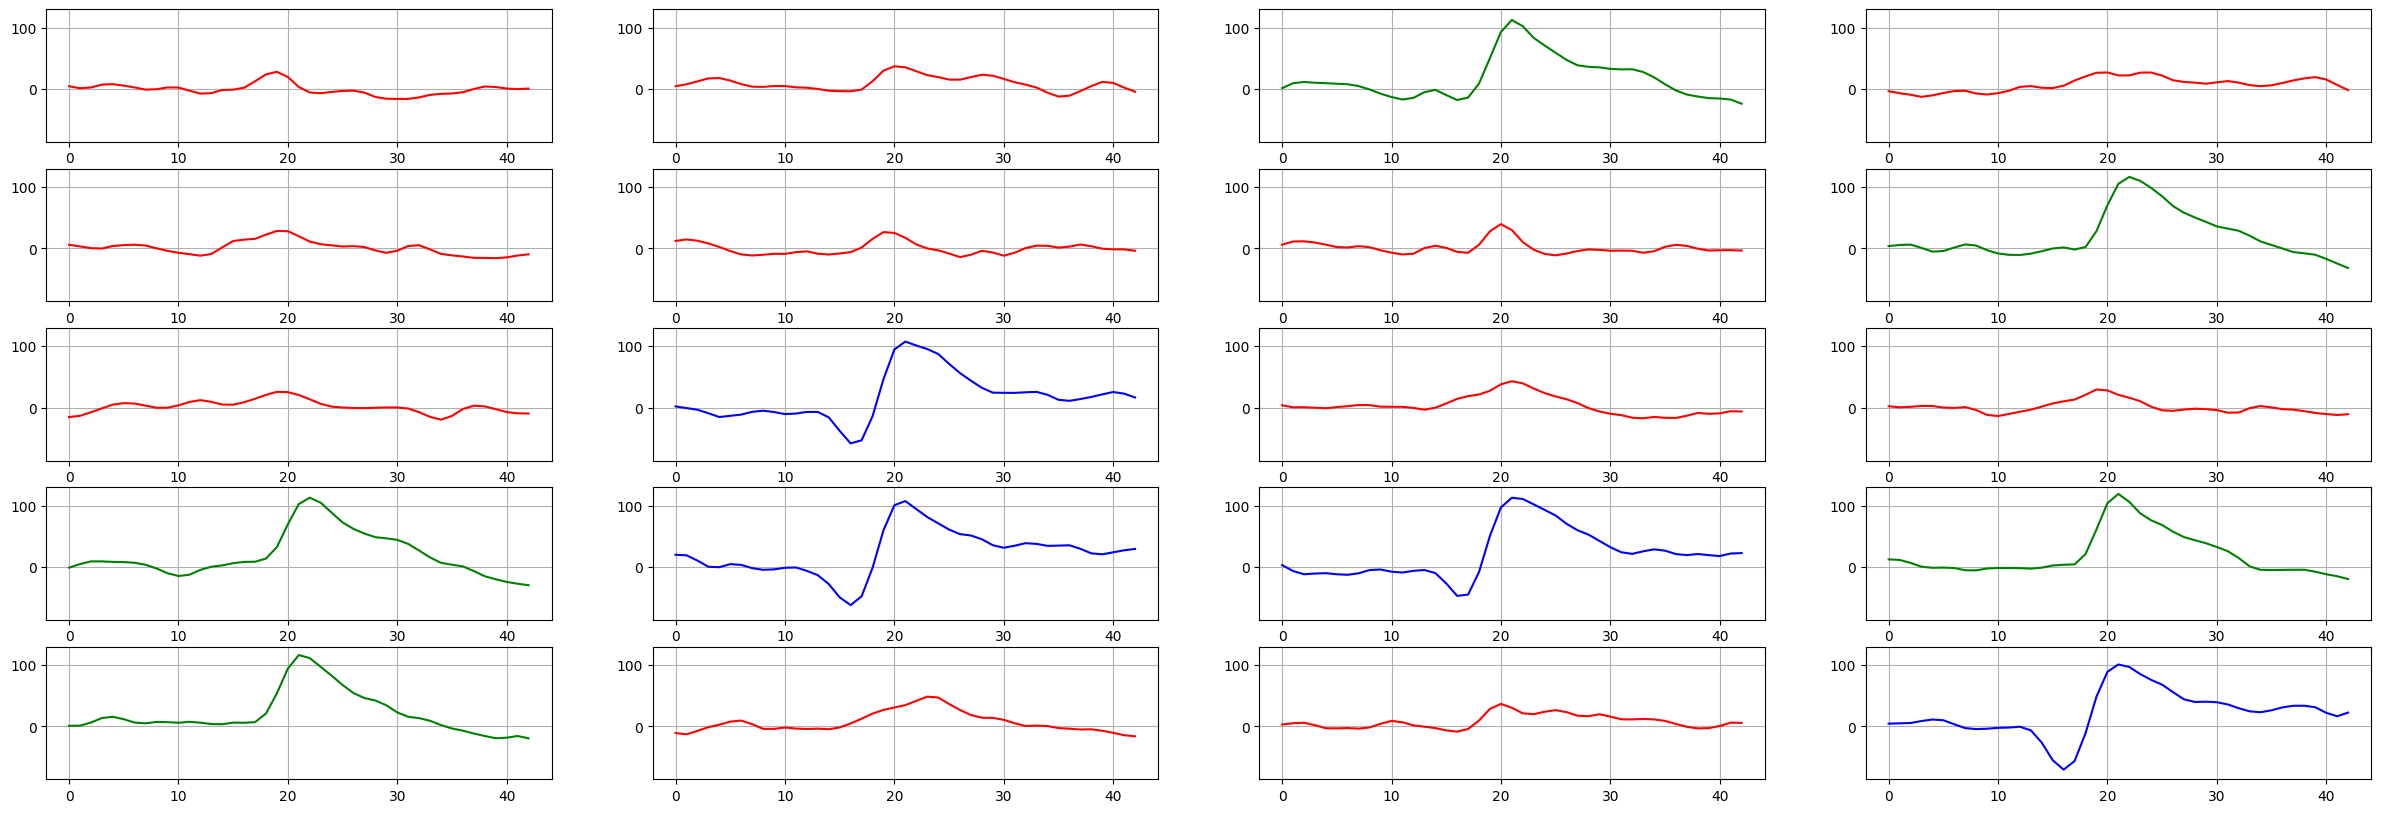

In [110]:
# apply final clustering algorithm based on optimal number of clusters
n_clusters = 3
kmeans_final = KMeans(n_init=10, n_clusters=n_clusters)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b', 'orange']

# plot first 20 spikes in different colors to see if clustering worked
plt.figure(figsize=(30, 10))
for i, spike in enumerate(spikes[:20]):
    plt.subplot(5, 4, i + 1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(spike, c=colors[classes[i]])
plt.show()

# References:
1. Estimating the number of clusters in a data set via the gap statistic Robert Tibshirani, Guenther Walther and Trevor Hastie Stanford University, USA
2. https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29
3. https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb
4. https://anaconda.org/milesgranger/gap-statistic/notebook?version=2016.04.25.1430